<a href="https://colab.research.google.com/github/konderal333/HGT-2022-EmDomArDon/blob/main/bert2bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load models and data

In [1]:
!git clone https://github.com/konderal333/HGT-2022-EmDomArDon.git

fatal: destination path 'HGT-2022-EmDomArDon' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import re

In [3]:
df = pd.read_csv('/content/HGT-2022-EmDomArDon/cikkek_10k_cleanedv1.csv')

In [4]:
print(df.isnull().values.any())
print(sum(df.duplicated()))

True
87


In [5]:
df = df.dropna()
df = df.drop_duplicates()

In [6]:
df = df.apply(lambda x: x.str.strip())
df['Textbody'] = df['Textbody'].apply(lambda x: re.sub(r"(\.)([A-Z])", r'\1 \2', str(x))) # add missing whitespace between sentences

df['Lead'] = df['Title'] + '. ' + df['Headline'] # maybe only headline and drop title?
df = df.drop(['Title', 'Headline'],axis=1)
df.head()

#reindexing the dataframe
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('SZTAKI-HLT/hubert-base-cc')

In [9]:
# bert2bert
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5" -O model_bert2bert.tar.gz && rm -rf /tmp/cookies.txt

# model
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GEdOmmKZEJOD2Ei28FtVEf534-nBEcBd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GEdOmmKZEJOD2Ei28FtVEf534-nBEcBd" -O model.tar.gz && rm -rf /tmp/cookies.txt

--2022-11-26 10:55:32--  https://docs.google.com/uc?export=download&confirm=t&id=1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5
Resolving docs.google.com (docs.google.com)... 172.253.117.139, 172.253.117.102, 172.253.117.113, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a3sdd38gc3a2dr0bcmr70qrjlodsdvtd/1669460100000/03710960119062529382/*/1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5?e=download&uuid=587b8929-03eb-4b81-97d0-6a48fbca35a0 [following]
--2022-11-26 10:55:32--  https://doc-0o-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a3sdd38gc3a2dr0bcmr70qrjlodsdvtd/1669460100000/03710960119062529382/*/1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5?e=download&uuid=587b8929-03eb-4b81-97d0-6a48fbca35a0
Resolving doc-0o-18-docs.googleusercontent.com (doc-0o-18-docs.googleusercontent.com)... 74.125.135.1

In [10]:
import shutil
shutil.unpack_archive('model.tar.gz', 'model')
shutil.unpack_archive('model_bert2bert.tar.gz', 'bert2bert')

In [11]:
import torch
from transformers import EncoderDecoderModel

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

bert2bert_model_path = '/content/bert2bert/model/pytorch_model.bin'
bert2bert_config = '/content/bert2bert/model/config.json'

model_path = '/content/model/model/pytorch_model.bin'
config = '/content/model/model/config.json'

#bert2bert = EncoderDecoderModel.from_pretrained(bert2bert_model_path, config=bert2bert_config).to(device)
model = EncoderDecoderModel.from_pretrained(model_path, config=config).to(device)

https://colab.research.google.com/drive/1WIk2bxglElfZewOHboPFNj8H44_VAyKE?usp=sharing&fbclid=IwAR2-pdnudSutvgqIlUUg4NP1Q0wJO9NQbteg_wVL9n8gsS2yMTfMp9YfC6w#scrollTo=bYmdx-W1NAky

## Data stats

In [12]:
# # map article and summary len to dict as well as if sample is longer than 512 tokens
# def map_to_length(x):
#   x["article_len"] = len(tokenizer(x["Textbody"]).input_ids)
#   x["article_longer_512"] = int(x["article_len"] > 512)
#   x["summary_len"] = len(tokenizer(x["Lead"]).input_ids)
#   x["summary_longer_64"] = int(x["summary_len"] > 64)
#   x["summary_longer_128"] = int(x["summary_len"] > 128)
#   return x

In [13]:
# data_stats = df.apply(map_to_length, axis=1)

In [14]:
# def compute_and_print_stats(x):
#   print(
#       "Article Mean: {}, %-Articles > 512:{}, Summary Mean:{}, %-Summary > 64:{}, %-Summary > 128:{}".format(
#           x["article_len"],
#           x["article_longer_512"],
#           x["summary_len"],
#           x["summary_longer_64"],
#           x["summary_longer_128"],
#       )
#   )

In [15]:
# output = data_stats.apply(compute_and_print_stats, axis=1)

#Function to handle larger inputs than 512 tokens

In [16]:
!pip install quntoken
from quntoken import tokenize   #module to break text into sentences

import re
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 7.4 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
dict_of_tokens = {} 
#this dict will contain the article title as keys and the tokenized lists from the function below as values

def text_to_tokens(art_title, x):      
  #insert the text to tokenize; first breaks text into sentences, then makes a list of lists with the i-th element being the tokenization of the i-th sentence
  #dictionary is being used for faster computation and easier accessibility
  sentence_list = []
  token_list = []

  x = re.sub(r"(\.)([A-Z])", r'\1 \2', x) # fixes missings whitespaces between sentences
 
  for sen in nltk.tokenize.sent_tokenize(x):
    sentence_list.append(sen)
    token_list.append(tokenizer.tokenize(sen))

  dict_of_tokens[art_title] = token_list

# making the BERT tokenized sentences from each article
for i in range(len(df.Lead)):
  text_to_tokens(df.Lead[i].strip(), df.Textbody[i])

Some basic statistics about the number of tokens

In [18]:
import matplotlib.pyplot as plt
import statistics

number_of_tokens_all = []

for tokens in dict_of_tokens.values():
  length = 0
  for lists in tokens:
    length += len(lists)
  number_of_tokens_all.append(length)


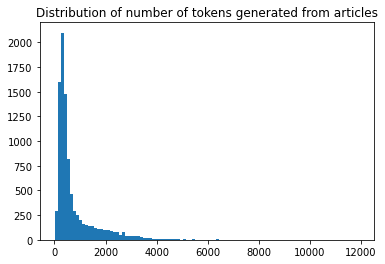

In [19]:
plt.hist(number_of_tokens_all, bins=100, density=False)
plt.title('Distribution of number of tokens generated from articles')
plt.show()

In [20]:
print("Median of tokens: ", statistics.median(number_of_tokens_all))
print("Mean of tokens: ", statistics.mean(number_of_tokens_all))

Median of tokens:  420.0
Mean of tokens:  765.9577029618581


In [21]:
# number of articles with tokens more that 510:
print(np.sum(np.asarray(number_of_tokens_all) > 510))

3749


## Process data

In [12]:
def process_data_to_model_inputs(batch):
        # Tokenize the input and target data
        inputs = tokenizer(batch['Textbody'], padding='max_length', truncation=True, max_length=512)
        outputs = tokenizer(batch['Lead'], padding='max_length', truncation=True, max_length=512)

        batch['input_ids'] = inputs.input_ids
        batch['attention_mask'] = inputs.attention_mask
        batch['decoder_input_ids'] = outputs.input_ids
        batch['decoder_attention_mask'] = outputs.attention_mask
        batch['labels'] = outputs.input_ids.copy()

        # batch['labels'] = [[-100 if token == tokenizer.pad_token_id else token for token in labels]
        #                    for labels in batch['labels']]
        batch['labels'] = [-100 if token == tokenizer.pad_token_id else token for token in batch['labels']]

        return batch

In [13]:
# just to make it faster
train_data = df.iloc[0:20]
val_data = df.iloc[20:30]
test_data = df.iloc[30:40]

# resetting the indeces
train_data.reset_index(inplace=True)
val_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

train_data = train_data.drop(['index'], axis=1)
val_data = val_data.drop(['index'], axis=1)
test_data = test_data.drop(['index'], axis=1)

In [14]:
train_data = train_data.apply(process_data_to_model_inputs, axis=1)
train_data = train_data.drop(['Textbody', 'Lead'], axis=1)

val_data = val_data.apply(process_data_to_model_inputs, axis=1)
val_data = val_data.drop(['Textbody', 'Lead'], axis=1)

In [15]:
train_data.head()

,input_ids,attention_mask,decoder_input_ids,decoder_attention_mask,labels
0,"[2, 2155, 7155, 2524, 4046, 4341, 15269, 14826...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 21086, 2018, 6480, 2045, 26204, 14350, 804...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 21086, 2018, 6480, 2045, 26204, 14350, 804..."
1,"[2, 30196, 9688, 11787, 11628, 2005, 11149, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 28589, 6997, 2039, 5833, 6505, 2094, 2005,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 28589, 6997, 2039, 5833, 6505, 2094, 2005,..."
2,"[2, 4405, 2546, 8984, 3576, 2079, 2005, 16667,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 5388, 28306, 7996, 2005, 16667, 3021, 2653...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 5388, 28306, 7996, 2005, 16667, 3021, 2653..."
3,"[2, 22158, 6688, 29536, 2005, 13549, 31735, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 12930, 12887, 6704, 7671, 2837, 20664, 297...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 12930, 12887, 6704, 7671, 2837, 20664, 297..."
4,"[2, 10708, 11447, 2685, 2066, 9763, 31736, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2930, 29814, 2066, 9763, 2033, 2718, 31741...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2930, 29814, 2066, 9763, 2033, 2718, 31741..."


In [16]:
%%capture
!pip install datasets

In [17]:
# converting to arrow dataset (easier to use)
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

train_data = Dataset(pa.Table.from_pandas(train_data))
val_data = Dataset(pa.Table.from_pandas(val_data))

# format type
train_data

Dataset({
    features: ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'],
    num_rows: 20
})

In [18]:
#converting to tensor
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

In [19]:
#old function

# def to_tensor(x):
#   for col in x.keys():
#     x[col] = torch.Tensor(x[col])
#   return x

# train_data = train_data.apply(to_tensor)
# val_data = val_data.apply(to_tensor)

In [20]:
# example
train_data["labels"]

tensor([[    2, 21086,  2018,  ...,  -100,  -100,  -100],
        [    2, 28589,  6997,  ...,  -100,  -100,  -100],
        [    2,  5388, 28306,  ...,  -100,  -100,  -100],
        ...,
        [    2,  2038, 25816,  ...,  -100,  -100,  -100],
        [    2, 13639,  3412,  ...,  -100,  -100,  -100],
        [    2,  9897, 15234,  ...,  -100,  -100,  -100]])

## Predict

In [21]:
def generate_summary(batch):
    # cut off at BERT max length 512
    inputs = tokenizer(batch['Textbody'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    input_ids = inputs.input_ids.to('cuda')
    attention_mask = inputs.attention_mask.to('cuda')

    outputs = model.generate(input_ids, attention_mask=attention_mask) # the same doesn't work with bert2bert, why?? Donát: it works, but isn't very good

    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch['pred_summary'] = output_str

    return batch

In [22]:
# example
batch = df.iloc[10]
batch['Textbody']

'Találkozni szeretett volna a Kölcsey Ferenc Gimnázium tanárait menesztő tankerületi vezetővel Soproni Tamás, terézvárosi polgármester. Marosi Betrix azonban nem látta indokoltnak, hogy beszélgessenek. A tankerületi vezető levelét Facebook-oldalán tette közzé a Momentum politikusa. Azt írja Marosi, hogy „természetesen a tankerületi központnak is az az érdeke, hogy az iskolában a helyzet normalizálódjon, a pedagógusok tanítsanak, a diákok tanuljanak”. A nevelés-oktatás feltételeinek biztosítása a VI. kerület állami fenntartású iskoláiban a tankerület feladata és felelőssége,„a tankerületi központ sem kíván beleszólni abba, hogy az Önkormányzat hogyan és kikkel látja el a feladatait.”A tankerületi vezető nem látja indokoltnak, hogy személyesen is találkozzon a kerület polgármesterével, mert a munkáltatói intézkedés „kizárólag a hatályos jogszabályokból fakadó lépés volt”. Marosi szerint az érintett pedagógusok a többszöri figyelmeztetés ellenére is visszatérően megszegték „a pedagógus jo

In [23]:
# Now the summary
inputs = tokenizer(batch['Textbody'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
input_ids = inputs.input_ids.to('cuda')
attention_mask = inputs.attention_mask.to('cuda')
outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=50)
output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
output_str

['Soproni Tamás szerint a tankerületi központnak is az az érdeke, hogy a tanárok és diákok tanuljanak.']

In [24]:
# let's see the tokens
for t in input_ids:
    print(tokenizer.convert_ids_to_tokens(t))

['[CLS]', 'Találkoz', '##ni', 'szeretett', 'volna', 'a', 'Kölcs', '##ey', 'Ferenc', 'Gimnázium', 'tanára', '##it', 'men', '##esztő', 'tank', '##erületi', 'vezető', '##vel', 'Sopron', '##i', 'Tamás', ',', 'ter', '##éz', '##városi', 'polgármester', '.', 'Maros', '##i', 'Bet', '##rix', 'azonban', 'nem', 'látta', 'indokolt', '##nak', ',', 'hogy', 'beszélg', '##essenek', '.', 'A', 'tank', '##erületi', 'vezető', 'level', '##ét', 'Facebook', '-', 'oldalán', 'tette', 'közzé', 'a', 'Mo', '##ment', '##um', 'politikus', '##a', '.', 'Azt', 'írja', 'Maros', '##i', ',', 'hogy', '„', 'természetesen', 'a', 'tank', '##erületi', 'központ', '##nak', 'is', 'az', 'az', 'érdeke', ',', 'hogy', 'az', 'iskolában', 'a', 'helyzet', 'norm', '##alizál', '##ódjon', ',', 'a', 'pedagógusok', 'tanít', '##sanak', ',', 'a', 'diákok', 'tanul', '##janak', '”', '.', 'A', 'nevelés', '-', 'oktatás', 'feltételeinek', 'biztosítása', 'a', 'VI', '.', 'kerület', 'állami', 'fenntart', '##ású', 'iskol', '##áiban', 'a', 'tank', '##e

In [25]:
batch_size = 64

results = test_data.apply(generate_summary, axis=1)
results = results.drop(['Textbody'], axis=1)
results

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


,Lead,pred_summary
0,Letartóztatták Vietnám leggazdagabb és legtito...,"[A kínai ingatlanmágnás, Truong Kn - ven ( mag..."
1,Futóverseny miatt forgalomkorlátozások lesznek...,[A futóverseny miatt több forgalmas futóesemén...
2,"Egy futópár is feltartóztathatatlan, ha jól tá...",[A sakkrejtvény - sorozat harmadik fordulójába...
3,Orbán Viktor egykori iskolája is szolidaritást...,[A székesfehérvári Teleki Blanka Gimnázium tan...
4,"Perelnek a szülők, miután a magas energiaárakr...",[A tankerület szerint ez nem a településre tar...
5,Verstappen egy századdal nyerte az év legszoro...,[A Mercedes kettős győzelmével zárult a 2022 -...
6,Már tíz százalék feletti régióban vannak egyes...,[A bankok fele már 10 százalék feletti kamatta...
7,"A fő kérdés, hogy arányos válasz-e a tanárok k...",[A Társaság a Szabadságjogokért ( TASZ ) jogvé...
8,Márta István Vidnyánszkyról: Soha nem fogom me...,"[A fesztiválalapításról, a politikai hatalomró..."
9,"A Hatalom Gyűrűi kezd kifutni az időből, de ez...",[A Hatalom Gyűrűi múlt heti eseményei után a v...


In [26]:
#Example of the lead, result and original text
print('ORIGINAL LEAD')
print(results.iloc[3]['Lead'])
print("")
print('PREDICTION')
print(results.iloc[3]['pred_summary'][0])
print("")
print('OIRGINAL TEXT')
test_data.iloc[3]['Textbody']


ORIGINAL LEAD
Orbán Viktor egykori iskolája is szolidaritást vállal a kirúgott pedagógusokkal. A Teleki Blanka Gimnázium 55 tanára írta alá a közleményt.

PREDICTION
A székesfehérvári Teleki Blanka Gimnázium tanárai kiálltak a tanárok mellett.

OIRGINAL TEXT


'A Székesfehérvári Teleki Blanka Gimnázium és Általános Iskola 55 tanára az intézmény hivatalos Facebook oldalán közzétett nyilatkozatukban álltak ki az elmúlt napokban kirúgott kollégáik mellett. Ebbe az iskolába járt Orbán Viktor, miniszterelnök is, aki tavaly májusban egy, az iskolánál készült videóban azt mondta, hogy hálával gondol a volt tanáraira, akik megpróbáltak belőle embert faragni.„Kiállunk a megfélemlítettek, a véleményüket vállalni nem merők, a meghurcoltak, az azonnali hatállyal munkából felmentettek mellett.”A közleményben, amit 48-an névvel, még heten név nélkül írtak alá, azt írják, hogy kiállnak mindenki mellett, akit elmúlt években, évtizedekben hátrány ért, mert a jobbá tétel szándékával fel mert szólalni az oktatásügy akkori vagy jelenlegi állapota ellen. Továbbá elutasítják azt, hogy az oktatás összetett és szerteágazó problémáit a megkérdezésünk nélkül, valódi párbeszéd nélkül, felülről, erőből, parancsszóval próbálják megoldani. Emellett felhívták arra a figye

In [27]:
# TODO: Rouge and human evaluation 

## Train further

In [28]:
#already default
#model.config.decoder_start_token_id == tokenizer.cls_token_id
#model.config.eos_token_id == tokenizer.sep_token_id
#model.config.pad_token_id == tokenizer.pad_token_id
#model.config.vocab_size == model.config.encoder.vocab_size

True

In [29]:
#még nem akarom állítgatni
#model.config.max_length = 142
#model.config.min_length = 56
#model.config.no_repeat_ngram_size = 3
#model.config.early_stopping = True
#model.config.length_penalty = 2.0
#model.config.num_beams = 4

In [30]:
%%capture
!rm seq2seq_trainer.py
!rm seq2seq_training_args.py
!wget https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/seq2seq/seq2seq_trainer.py
!wget https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/seq2seq/seq2seq_training_args.py

In [31]:
%%capture
!pip install git-python==1.0.3
!pip install rouge_score
!pip install sacrebleu

In [32]:
from seq2seq_trainer import Seq2SeqTrainer
from seq2seq_training_args import Seq2SeqTrainingArguments

In [33]:
batch_size = 10

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True, 
    output_dir="./output",
    logging_steps=2,
    save_steps=10,
    eval_steps=4
    # logging_steps=1000,
    # save_steps=500,
    # eval_steps=7500,
    # warmup_steps=2000,
    # save_total_limit=3,
)

In [35]:
import datasets
rouge = datasets.load_metric("rouge")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [36]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [37]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 6
  Number of trainable parameters = 249636609


RuntimeError: ignored